In [1]:
"""
Sources:

2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

https://www.bloomberg.com/graphics/world-economic-indicators-dashboard/?leadSource=uverify%20wall

- Hierarchical TS: https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

-Read this after workout: https://www.kaggle.com/code/gargaar/time-series-with-python

"""



'\nSources:\n\n2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a\n\n'

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta
from sklearn.model_selection import TimeSeriesSplit

#color_pal = sns.color_palette()
#plt.style.use('fivethirtyeight')


In [122]:
def first_day_of_month(date):
    """
    Sets all dates to first day of the month
    
    :param date: date object
    
    :return: date object with day replaced with one
    """
    year = date.year
    month = date.month
    return pd.datetime(year, month, 1)

def add_lags(df, num_lags, feature_lag_lst):
    """
    
    :param df: data frame to add lags to
    :param num_lags: # of lags
    :param feature_lag_lst: features to add lags to
    
    :return df, lag_lst: data frame with lags and list of lags
    """
    df = df.copy()
    lag_lst = []
    for feature in feature_lag_lst:
        target_map = df[feature].to_dict()
        for lag in range(1, num_lags):
            df[f'{feature}_lag_{lag}'] = (df.index - pd.DateOffset(months=lag)).map(target_map)
            lag_lst.append(f'{feature}_lag_{lag}')
        
    # df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364
    # df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # 728
    # df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # 1092
    return df, lag_lst

def generate_lagged_features_lst(lagged_attr, num_lags):
    """
    Generates a lagged feature list
    TODO: lag_lst from above can probably replace this
    
    :param lagged_attr: attributes to add the "lag_#" tag
    :param num_lags: number of lags
    
    :return features: list of features with the "lag_#" tag
    """
    
    features = []
    for attr in lagged_attr:
        for i in range(1,num_lags):
            features.append(f"{attr}_lag_{i}")
    return features

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

In [123]:
def preprocess(df):
    df = df.copy()
    df.columns = [signal.lower().replace(" ", "_") for signal in df.columns] # upper to lower and replace space with underscores
    df['date'] = pd.to_datetime(df['date']) # To date-time object conversion
    df = df.resample('M', on='date').mean() # Up-sample
    df.index = df.index.map(first_day_of_month) # Set index
    return df

In [142]:
qqq_df = pd.read_csv("QQQ.csv")
nvda_df = pd.read_csv("NVDA.csv")
spy_df = pd.read_csv("SPY.csv")
vti_df = pd.read_csv("VTI.csv")


qqq_df = preprocess(qqq_df)
nvda_df = preprocess(nvda_df)
spy_df = preprocess(spy_df)
vti_df = preprocess(vti_df)


df = nvda_df.copy()
df["qqq_close"] = qqq_df["close"]
df["spy_close"] = spy_df["close"]
df["vti_close"] = vti_df["close"]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


## Train/Test Cross Validation

In [143]:
feature_df = create_features(df)
TARGET = ["close"] # , "vti_close"
time_based_features = []# ["quarter", "month", "year"]
feature_df = feature_df[TARGET + time_based_features]
feature_df

,close
date,
2000-01-01,0.886068
2000-02-01,1.101628
2000-03-01,1.870429
2000-04-01,1.746214
2000-05-01,2.005001
...,...
2022-08-01,177.622608
2022-09-01,131.744284
2022-10-01,124.698095


## Decision Trees

In [144]:
feature_df['y'] = feature_df['close'].shift(-1)


In [145]:
train_size = round(len(feature_df)*.80)

In [128]:
train = feature_df[:train_size]
test = feature_df[train_size:]
test = test.drop(test.tail(1).index) # Drop last row
test['baseline_pred'] = test['close'] # Baseline -> input = output


In [129]:
from sklearn.tree import DecisionTreeRegressor

X_train = train['close'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['close'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

# view the model 
test.head(10)

,close,y,baseline_pred,dt_pred
date,,,,
2018-06-01,64.117380,62.167500,64.117380,64.11738
2018-07-01,62.167500,65.206848,62.167500,64.11738
2018-08-01,65.206848,67.977763,65.206848,64.11738
2018-09-01,67.977763,60.006848,67.977763,64.11738
2018-10-01,60.006848,45.301190,60.006848,56.49131
2018-11-01,45.301190,35.915000,45.301190,48.15125
2018-12-01,35.915000,36.248452,35.915000,39.85750
2019-01-01,36.248452,38.295132,36.248452,39.85750
2019-02-01,38.295132,41.831071,38.295132,39.85750


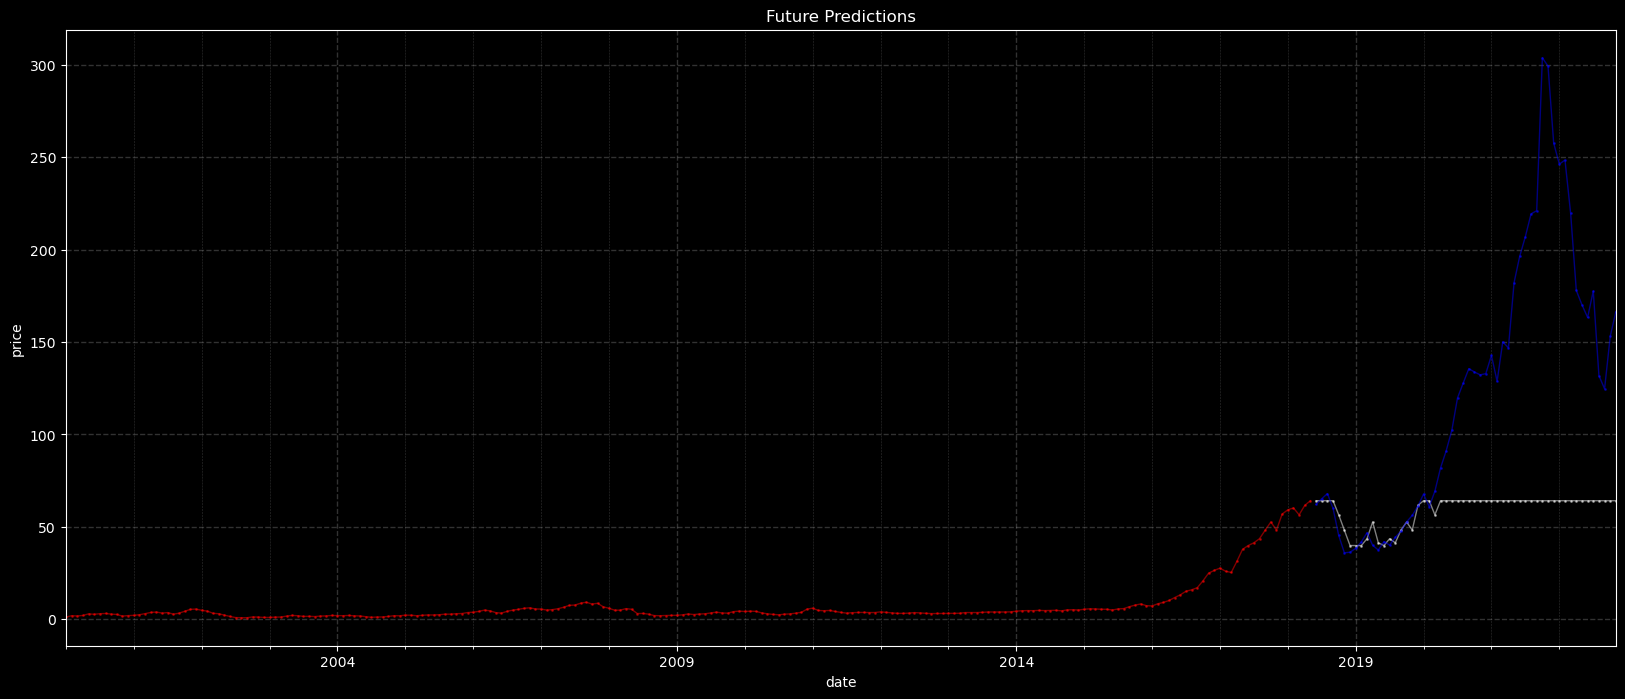

In [130]:
#Plot Values
plt.style.use('dark_background')

#Behaves like this because training data has never see data go higher
fig, ax = plt.subplots()
train['y'].plot(figsize=(20, 8),
                               color="red",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
test['dt_pred'].plot(figsize=(20, 8),
                               color="white",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
test['y'].plot(figsize=(20, 8),
                               color="blue",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

#ax.axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
ax.grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
ax.grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
#fig.autofmt_xdate()
plt.show()

## Gradient Boosting

In [131]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

#Check the output
test.head(10)

,close,y,baseline_pred,dt_pred,gbr_pred
date,,,,,
2018-06-01,64.117380,62.167500,64.117380,64.11738,63.971458
2018-07-01,62.167500,65.206848,62.167500,64.11738,63.971458
2018-08-01,65.206848,67.977763,65.206848,64.11738,63.971458
2018-09-01,67.977763,60.006848,67.977763,64.11738,63.971458
2018-10-01,60.006848,45.301190,60.006848,56.49131,56.752306
2018-11-01,45.301190,35.915000,45.301190,48.15125,48.050945
2018-12-01,35.915000,36.248452,35.915000,39.85750,39.835054
2019-01-01,36.248452,38.295132,36.248452,39.85750,39.835054
2019-02-01,38.295132,41.831071,38.295132,39.85750,39.835054


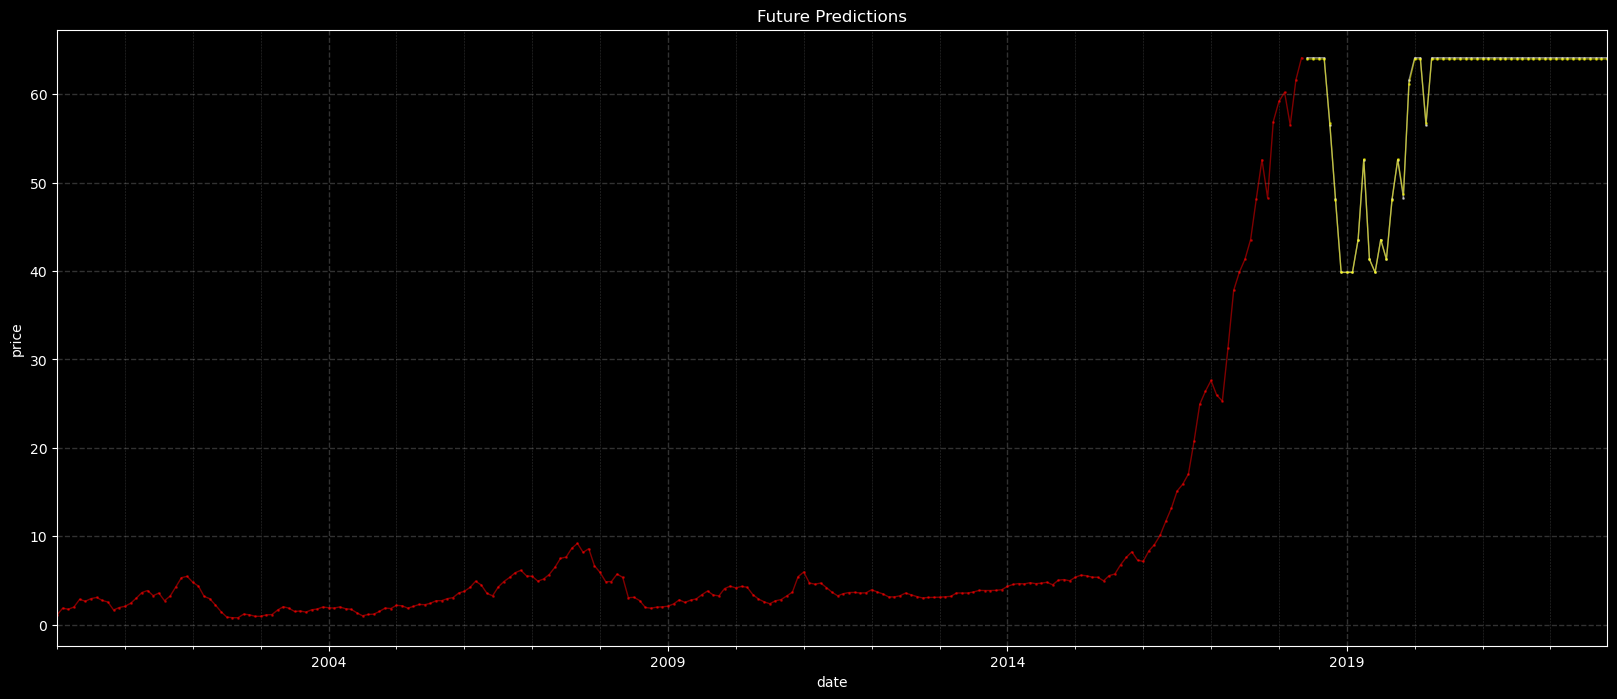

In [132]:
#Plot Values
plt.style.use('dark_background')

#Behaves like this because training data has never see data go higher
fig, ax = plt.subplots()
train['y'].plot(figsize=(20, 8),
                               color="red",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
test['dt_pred'].plot(figsize=(20, 8),
                               color="white",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
test['gbr_pred'].plot(figsize=(20, 8),
                               color="yellow",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
# test['y'].plot(figsize=(20, 8),
#                                color="blue",
#                                ms=1,
#                                lw=1,
#                                title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

#ax.axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
ax.grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
ax.grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
#fig.autofmt_xdate()
plt.show()

In [133]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

Text(0, 0.5, 'MAPE (%)')

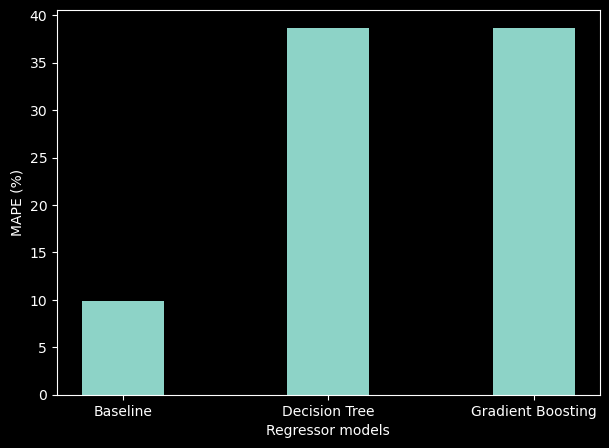

In [141]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 0.3)
# for index, value in enumerate(y):
#     plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
# plt.tight_layout()

In [219]:
"""
Retrofitted for all data

"""

def recursive_forecast(df, target_lst, horizon, num_lags):
    """
    Produce forecasts on feature engineered data frame (e.g. lagged and categorical features...)
    
    :param df: featured engineered data frame
    """
    for forecast_step in reversed(range(0, horizon)):
        global step_ahead_df
        # Forecast
        res = dt_reg.predict(df['y'].tail(1).values.reshape(-1,1)) # Predict using features | [Last Total Rows Generated, Specific Row from the end]
        print(res)
        future_date = df.index.max() + relativedelta.relativedelta(months=1) # Derive future date
        print(future_date)
        step_ahead_forecast = {'date': future_date, 'isFuture': True}
        for idx, target in enumerate(target_lst): # Save forecast 
            step_ahead_forecast[target] = res # forecast is in the follow format: [[val_1, val_2, ...]]
        
        step_ahead_df = pd.DataFrame(step_ahead_forecast, index = [0]) # Save forecast result in step ahead. Index set to zero to use scalars
        step_ahead_df.set_index("date", inplace= True)
        #step_ahead_df = create_features(step_ahead_df) # Create features for latest row of data
        df = pd.concat([df, step_ahead_df]) # Combine new row of data with existing row
        #df, _ = add_lags(df, num_lags, target_lst) # Add lags to the latest row of data

        
    return df

feature_df = feature_df.drop(feature_df.tail(1).index)
dt_reg.fit(X=feature_df['close'].values.reshape(-1,1), y=feature_df['y'].values.reshape(-1,1))

FEATURES = ["close"]
temp = recursive_forecast(feature_df, ["y"], 18, 10)